
# Wood Surface Defect Classification (3 Classes)

This notebook uses the **WoodSurface_dataset** folder, which already contains
separate `train`, `validation`, and `test` subsets with the following class labels:

- `0` – good boards (no visible defects)  
- `1` – live knots  
- `2` – dead knots  

The goal is to train and evaluate image classifiers that can distinguish between
these three surface conditions.

In this notebook we train a **VGG16-based transfer learning model** for the
3-class wood surface classification task. The model uses early stopping and
model checkpointing, and we further apply an optional fine-tuning stage on
the pre-trained convolutional base.



## 1. Library imports and device configuration

This section:

- Imports all required Python and Keras/TensorFlow modules.  
- Checks whether a GPU is available.  
- If a GPU is found, it enables **memory growth** so that TensorFlow does not
  occupy all GPU memory at once.


In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

# Print the TensorFlow version for reference
print("TensorFlow version:", tf.__version__)

# Check whether a GPU is available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("GPU is available. Using GPU for training when possible.")
    try:
        # Enable dynamic GPU memory growth (safer on shared machines)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Could not set memory growth:", e)
else:
    print("No GPU found. Training will run on CPU.")


TensorFlow version: 2.20.0
No GPU found. Training will run on CPU.



## 2. Data loading and data augmentation

Here we:

- Specify the `WoodSurface_dataset` root directory.  
- Define the target image size and batch size.  
- Build three `ImageDataGenerator` objects:
  - `train_datagen` with data augmentation (rotation, shift, flip, zoom).  
  - `val_datagen` and `test_datagen` with only rescaling.  
- Use `flow_from_directory` to create training, validation, and test generators.
  Keras will infer class labels directly from the subfolder names `0`, `1`, `2`.


In [3]:

# Root directory of the prepared dataset
base_dir = "./WoodSurface_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Image size used for training (VGG16 expects at least 224x224)
img_size = (224, 224)

# Number of images processed in each gradient update
batch_size = 32

# We have 3 surface classes: 0 (good), 1 (live knot), 2 (dead knot)
num_classes = 3

# Data generator for the training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,   # Normalize pixel values to [0, 1]
    rotation_range=15,     # Random rotations
    width_shift_range=0.1, # Random horizontal shifts
    height_shift_range=0.1,# Random vertical shifts
    horizontal_flip=True,  # Flip images horizontally
    zoom_range=0.1         # Slight random zoom
)

# Validation and test sets are only rescaled (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Training generator: reads images from train/0, train/1, train/2
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"  # One-hot encoded labels for 3 classes
)

# Validation generator: reads images from validation/0,1,2
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Test generator: reads images from test/0,1,2
# Shuffle is disabled so that predictions align with true labels
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Show the mapping from folder names to numeric class indices
print("Class indices:", train_generator.class_indices)

# Reverse mapping: from numeric index back to folder name string ("0","1","2")
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
print("Index to class mapping:", idx_to_class)


Found 1060 images belonging to 3 classes.
Found 226 images belonging to 3 classes.
Found 229 images belonging to 3 classes.
Class indices: {'0': 0, '1': 1, '2': 2}
Index to class mapping: {0: '0', 1: '1', 2: '2'}



## 4. Transfer learning with VGG16

Next, we build a more powerful model using **VGG16 pre-trained on ImageNet**.
The steps are:

1. Load VGG16 without its top classification layers (`include_top=False`).  
2. Freeze all convolutional layers so they act as a fixed feature extractor.  
3. Add a new classification head for 3 classes.  
4. Train only the new head using our wood surface images.


In [4]:

# Load the pre-trained VGG16 base (without the final dense layers)
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(img_size[0], img_size[1], 3))
)

# Freeze all convolutional layers so their weights are not updated initially
for layer in base_model.layers:
    layer.trainable = False

# Build a new classification head on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)

# Combine base model and new head into a single model
tl_model = Model(inputs=base_model.input, outputs=outputs, name="VGG16_wood_3class")

# Compile the transfer learning model
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

tl_model.summary()


Model: "VGG16_wood_3class"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


### 4.1 Train the VGG16 transfer learning model

We use two callbacks to improve generalization and training stability:

- `EarlyStopping`: monitors validation loss and stops training if it does not
  improve for several epochs.  
- `ModelCheckpoint`: saves the model weights corresponding to the best validation loss.


In [5]:

# Early stopping to prevent overfitting
earlystop = EarlyStopping(
    monitor="val_loss",  # Track validation loss
    mode="min",
    patience=8,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,
    verbose=1
)

# Directory to store the best model weights
model_dir = os.path.join(base_dir, "models")
os.makedirs(model_dir, exist_ok=True)
checkpoint_path = os.path.join(model_dir, "VGG16_wood_3class_best.keras")

# Model checkpoint: save the model with the lowest validation loss
checkpointer = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# Maximum number of epochs for transfer learning
epochs_tl = 30

history_tl = tl_model.fit(
    train_generator,
    epochs=epochs_tl,
    validation_data=val_generator,
    callbacks=[earlystop, checkpointer],
    verbose=1
)


C:\Users\28425\Desktop\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.3663 - loss: 1.2695
Epoch 1: val_loss improved from None to 1.06332, saving model to ./WoodSurface_dataset\models\VGG16_wood_3class_best.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3642 - loss: 1.1948 - val_accuracy: 0.4292 - val_loss: 1.0633
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3795 - loss: 1.1225
Epoch 2: val_loss improved from 1.06332 to 1.01931, saving model to ./WoodSurface_dataset\models\VGG16_wood_3class_best.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3858 - loss: 1.1109 - val_accuracy: 0.5354 - val_loss: 1.0193
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4166 - loss: 1.0635
Epoch 3: val_loss improved from 1.01931 to 0.98112, saving model to ./WoodSurface_dataset\models\VGG16_wood_3class_best.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4415 - loss: 1.0466 - val_accuracy: 0.5929 - val_loss: 0.9811
Epoch 4/30
34/34 ━━━━━━━━━━━


## 5. Training and validation curves

This helper function plots training and validation accuracy and loss curves
for a given Keras `History` object. The curves are useful to diagnose
overfitting or underfitting.


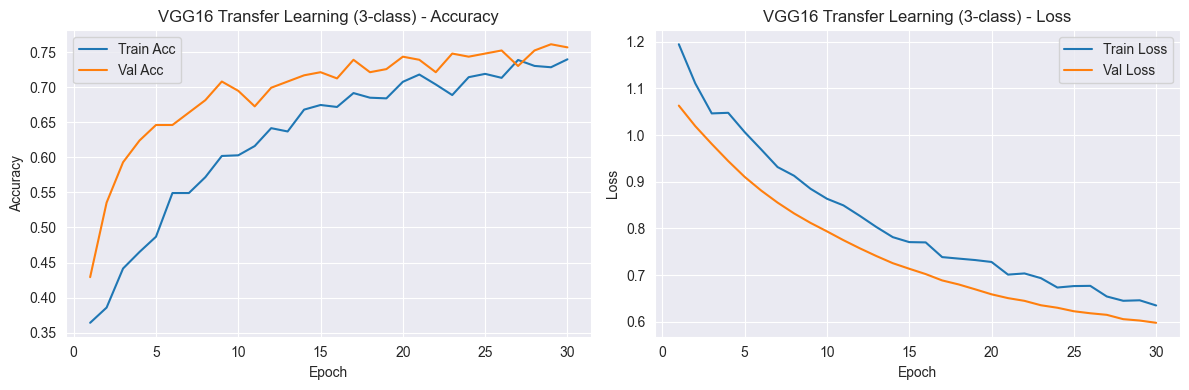

In [6]:

def plot_history(history, title_prefix="Model"):
    """Plot training and validation accuracy/loss curves."""
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.title(f"{title_prefix} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot the learning curves for the VGG16 transfer learning model
plot_history(history_tl, title_prefix="VGG16 Transfer Learning (3-class)")



## 6. Evaluation on the independent test set

We now evaluate the trained VGG16 model on the held-out test set.

The following metrics are reported:

- Overall accuracy.  
- Per-class precision, recall, and F1-score (`classification_report`).  
- Confusion matrix visualized as a heatmap.


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 894ms/step
Class label mapping: {0: 'good', 1: 'live knot', 2: 'dead knot'}

Classification report:
              precision    recall  f1-score   support

        good     0.8904    0.8667    0.8784        75
   live knot     0.7000    0.6203    0.6577        79
   dead knot     0.6977    0.8000    0.7453        75

    accuracy                         0.7598       229
   macro avg     0.7627    0.7623    0.7605       229
weighted avg     0.7616    0.7598    0.7587       229



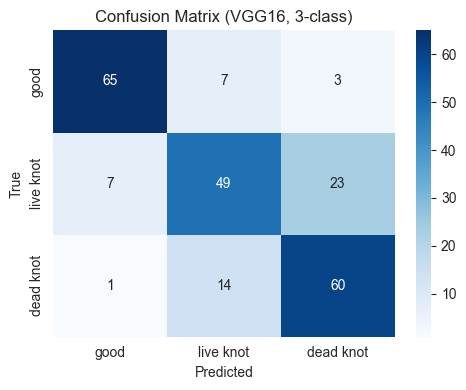

In [7]:
# ============================
# 6. Evaluation on the test set
# ============================

# Reset the generator so that we iterate from the beginning
test_generator.reset()

# Predict class probabilities for all test images
y_prob = tl_model.predict(test_generator, verbose=1)

# Convert probabilities to predicted class indices (0, 1, 2)
y_pred = np.argmax(y_prob, axis=1)

# True labels provided by the generator (also 0, 1, 2)
y_true = test_generator.classes

# ---- Custom class name mapping ----
# Here we define human-readable labels for each numeric class:
# 0 -> good board
# 1 -> live knot
# 2 -> dead knot
class_labels = {
    0: "good",
    1: "live knot",
    2: "dead knot"
}

# Build a list of class names in numeric index order
target_names = [class_labels[i] for i in range(num_classes)]
print("Class label mapping:", class_labels)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,  # use readable class names on axes
    yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (VGG16, 3-class)")
plt.tight_layout()
plt.show()



## 7. fine-tuning of the VGG16 base

Fine-tuning allows us to slightly adjust some of the pre-trained convolutional
layers to better match the wood surface dataset.

Steps:

1. Unfreeze the last few layers of the VGG16 base.  
2. Recompile the model with a smaller learning rate.  
3. Train for a few additional epochs with early stopping.


Number of trainable layers after unfreezing: 8
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7717 - loss: 0.5548 - val_accuracy: 0.8186 - val_loss: 0.4691
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8189 - loss: 0.4379 - val_accuracy: 0.8496 - val_loss: 0.3920
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8660 - loss: 0.3610 - val_accuracy: 0.8717 - val_loss: 0.3463
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8764 - loss: 0.3247 - val_accuracy: 0.9027 - val_loss: 0.3057
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9019 - loss: 0.2793 - val_accuracy: 0.9027 - val_loss: 0.2739
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9009 - loss: 0.2624 - val_accuracy: 0.8938 - val_loss: 0.2598
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9123 - loss: 0.2344 - val_accuracy: 0.9159 - val_loss: 0.2392
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9264 - 

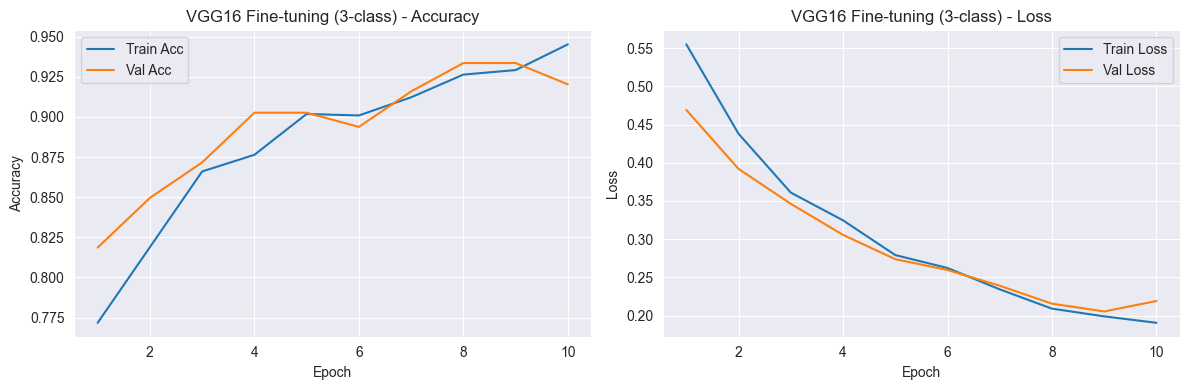

In [8]:

# Here we unfreeze the last 4 layers
fine_tune_at = len(base_model.layers) - 4

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile the model with a smaller learning rate to avoid large updates
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Number of trainable layers after unfreezing:",
      len([l for l in tl_model.layers if l.trainable]))

# Early stopping for the fine-tuning stage
earlystop_ft = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Number of additional epochs for fine-tuning
epochs_finetune = 10

history_ft = tl_model.fit(
    train_generator,
    epochs=epochs_finetune,
    validation_data=val_generator,
    callbacks=[earlystop_ft],
    verbose=1
)

# Plot fine-tuning learning curves
plot_history(history_ft, title_prefix="VGG16 Fine-tuning (3-class)")


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 821ms/step


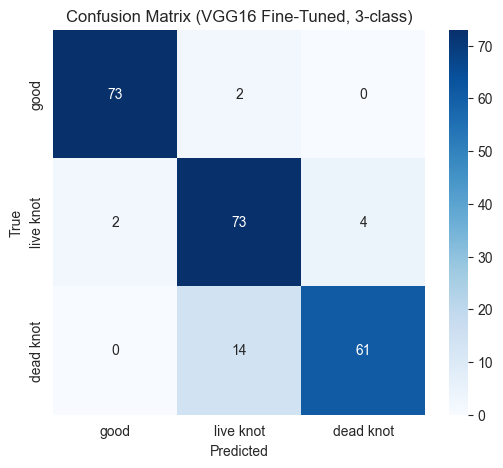

Classification Report:
              precision    recall  f1-score   support

        good       0.97      0.97      0.97        75
   live knot       0.82      0.92      0.87        79
   dead knot       0.94      0.81      0.87        75

    accuracy                           0.90       229
   macro avg       0.91      0.90      0.90       229
weighted avg       0.91      0.90      0.90       229



In [9]:

# Confusion Matrix (Final Fine-Tuned VGG16 Model)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
test_generator.reset()
y_prob = tl_model.predict(test_generator, verbose=1)   # probabilities
y_pred = np.argmax(y_prob, axis=1)                     # predicted class indices
y_true = test_generator.classes                        # true labels

# Class name mapping
class_labels = {
    0: "good",
    1: "live knot",
    2: "dead knot"
}
target_names = [class_labels[i] for i in range(num_classes)]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.title("Confusion Matrix (VGG16 Fine-Tuned, 3-class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report (optional but recommended)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))
